<a href="https://colab.research.google.com/github/jinInoue-rrr/from_scratch/blob/main/deep_from_scratch_ch4_NN_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4章　ニューラルネットワークの学習

## 4.1 データから学習する

<br />



In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
import os 
os.getcwd()

'/content'

In [3]:
os.chdir("/content/drive/My Drive/deep-learning-from-scratch-master/ch04")

In [4]:
os.getcwd()

'/content/drive/My Drive/deep-learning-from-scratch-master/ch04'

### 4.1.2

<br />

モデルの汎化能力が重要。汎化能力とは、まだ見ぬデータに対する予測能力のことである。過学習を避けるためにも、訓練データとテストデータをきちんと分けることが重要。

## 4.2 損失関数(loss function) 

<br />

一般には2乗和誤差や、交差エントロピー誤差などが用いられる。

### 4.2.1 2乗和誤差




In [5]:
# 2乗和誤差の実装
import numpy as np


def sum_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)



In [6]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
sum_squared_error(np.array(y), np.array(t))

0.09750000000000003

 ### 4.2.2 交差エントロピー誤差

 $E = -\sum_k t_k log{y_k} ... (4.2)$

 $t_k$は正解ラベルとなるインデックスだけが1となり、それ以外は0となるone-hot表現
 交差エントロピー誤差は、正解ラベルとなる出力の結果によって、その値が決まる。

In [7]:
#交差エントロピー誤差の実装

def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta)) ### deltaは微小な値であり、log(0)となってマイナス無限大の-infとならないようにしている。実装上の理由。

In [8]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

### 4.2.3 ミニバッチ学習

<br />

$E = -\frac{1}{N}\sum_n\sum_k t_{nk}log{y_{nk}} ... (4.3)$ 

MNISTでは、訓練データだけで60000もあるため、損失関数の計算も時間がかかる。そのため、全体からサブグループをランダムに抽出して、小規模な学習を行う手法を**ミニバッチ学習**という。

In [9]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

In [10]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize = True, one_hot_label = True)

In [11]:
print(x_train.ndim)

2


In [12]:
print(t_train.shape)

(60000, 10)


In [13]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)#ランダムにインデックスを選び出す
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [14]:
batch_mask

array([22102, 11631, 21433, 51149, 32182, 49734, 27594, 35892, 26402,
       13531])

In [15]:
### 4.2.4 バッチ対応版の交差エントロピー誤差の実装

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [16]:
#教師データがラベルとして与えられた時の、交差エントロピー誤差の実装

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### 4.2.5 なぜ損失関数を設定するのか？

<br />

最適なパラメータの探索の際には、損失関数の値ができるだけ小さくなるようなパラメータを探す。パラメータの微分を計算し、その微分の値を手掛かりに値を更新していく。
ある一つの重みパラメータの損失関数に関する微分は、その重みパラメータを少しだけ変化させたときに、損失関数がどのように変化するかを表している。しかし、微分が0になってしまうと、どちらの方向にも動かなくなってしまう。

## 4.3 

### 4.3.1 微分

<br />

ある瞬間の変化量を指す

<br />

##### 数値微分(numerical differentiation)



In [17]:
## 悪い実装例

def numerical_diff(f, x):
    h = 1e-50#極めて小さい値
    return (f(x+h) - f(x) ) / h

`1e-50`は極めて小さい値だが、これにより**丸め誤差(rounding error)**の問題が生じる

In [18]:
np.float32(1e-50)

0.0

In [19]:
#中心差分をとったマシな実装例

def numerical_diff(f, x):
    h = 1e-4#これくらいのオーダーで十分らしい
    return (f(x+h) - f(x-h)) / 2*h

### 4.3.2 数値微分の例


In [20]:
import numpy as np
import matplotlib.pylab as plt

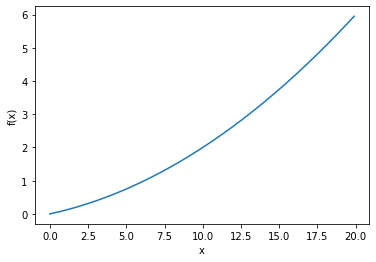

In [21]:
def function_1(x):
    return 0.01 * x **2 + 0.1 * x
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [22]:
numerical_diff(function_1, 5)

1.9999999999908982e-09

In [23]:
numerical_diff(function_1, 10)

2.999999999986347e-09

### 4.3.3 偏微分



In [24]:
def function_2(x):
    return x[0] ** 2 + x[1] ** 2#numpy配列の各要素の二乗和を計算するだけ

In [25]:
## x0 = 3, x1 = 4の時のx0に対する偏微分を求める

def function_tmp1(x0):
    return x0 * x0 + 4.0 ** 2.0#x1を4で固定して、x0についての関数として定義し直し、このx0について微分する

    

In [26]:
numerical_diff(function_tmp1, 3.0)

6.000000000003781e-08

## 4.4 勾配

$\nabla f = (\frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1})$

このように、それぞれの変数による偏微分をまとめたベクトルのことを勾配(gradient)という。

In [27]:
# 勾配の実装

def numerical_gradient(f, x):
    h = 1e-4#0.0001
    grad = np.zeros_like(x)#xと同じ形状の配列を作成し、0で初期化する
    #以下のfor loopはインデックス番号と変数の種類が対応している
    for idx in range(x.size):#rangeは0からx.size-1の番号まで。
        tmp_val = x[idx]#現在の値
        #f(x + h)の計算
        x[idx] = tmp_val + h#xからidxのインデックスの中身を取り出して、hを足して元に戻しているだけ
        fxh1 = f(x)

        #f(x - h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2 ) / (2*h)
        x[idx] = tmp_val#元に戻す

    return grad

In [28]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

### 勾配の性質

<br />

勾配が示す方向は、各地点において関数の値を最も減らす方向を指し示している点が重要

つまり、勾配の符号が更新の方向を定めるということ。。。。。

### 4.4.1 勾配降下法(gradient descent method)

機械学習の問題の多くは、学習の際に最適なパラメータを探索する。NNもまた、同様に重みとバイアスを学習時に見つけなければいけない。


### 勾配降下法（gradient descent method）



In [29]:
# 勾配降下法の実装

def numerical_gradient(f, x):#xはnumpy配列を想定している
    h = 1e-4#0.0001
    grad = np.zeros_like(x)#xと同じ形状の配列を作成し、0で初期化する
    #以下のfor loopはインデックス番号と変数の種類が対応している
    for idx in range(x.size):#rangeは0からx.size-1の番号まで。
        tmp_val = x[idx]#現在の値
        #f(x + h)の計算
        x[idx] = tmp_val + h#xからidxのインデックスの中身を取り出して、hを足して元に戻しているだけ
        fxh1 = f(x)

        #f(x - h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2 ) / (2*h)
        x[idx] = tmp_val#元に戻す

    return grad

def gradient_descent(f, init_x, lr = 0.01, step_num = 100):  #lr = learning rate:学習率であり、ハイパーパラメータ
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)#勾配を生成
        x -= lr * grad#ハイパーパラメータと勾配の積を引く


    return x


  #fは最適化したい関数、init_xは初期値、lrは学習率、step_numは勾配法による繰り返しの回数のこと

  







###### この関数を使うことによって、関数の極小値を得ることができる。うまくいけば最小値を求めることもできる


In [31]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [34]:
init_x = np.array([-3.0, 4.0])#適当な初期値からスタートして、探索することによって極小値を得ている。

In [35]:
gradient_descent(function_2, init_x = init_x, lr = 0.1, step_num = 100)#実際の最小値は(0, 0)なので、限りなく近い値を獲得することができている。


array([-6.11110793e-10,  8.14814391e-10])

In [36]:
#learning rateが大きすぎても、小さすぎてもうまくいかないことの例

init_x = np.array([-3.0, 4.0])

In [38]:
gradient_descent(function_2, init_x = init_x, lr = 10.0, step_num = 100)#学習率が大きすぎると発散してしまう

array([-2.58983747e+13, -1.29524862e+12])

In [39]:
#learning rateが小さすぎるとどうなるか

init_x = np.array([-3.0, 4.0])

In [40]:
gradient_descent(function_2, init_x = init_x, lr = 1e-10, step_num = 100)#ほとんど初期値から進まないのでこれだと意味がない

array([-2.99999994,  3.99999992])

In [44]:
#実行回数増やすとどうなるか

gradient_descent(function_2, init_x = init_x, lr = 1e-10, step_num = 1000)#10倍程度じゃ変わらないけど、かといって増やしすぎると学習に時間がかかるためバランスがむずかしい。多分普通は交差検証とかで決めるんだと思う。


array([-2.99927121,  3.99916161])

## 4.4.2 ニューラルネットワークに対する勾配

<br />

重みパラメータに関する、損失関数の勾配を求める！

In [45]:
# importする

import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

In [46]:
#simpleNet というクラスを実装する

class simpleNet:
      def __init__(self):
          self.W = np.random.randn(2, 3)
      
      def predict(self, x):
          return np.dot(x, self.W)

      def loss(self, x, t):
            z = self.predict(x)
            y = softmax(z)
            loss = cross_entropy_error(y, t)

            return loss


In [47]:
#試しに使ってみる

net = simpleNet()
print(net.W)#この段階だと、重みパラメータはガウス分布からランダムに生成された初期値が表示されている

[[-0.63142721 -1.26191328 -0.28376783]
 [-0.15424325 -1.07259063  0.53311632]]


In [48]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.51767525 -1.72247954  0.30954399]


In [49]:
np.argmax(p)

2

In [50]:
t = np.array([0, 0, 1])#正解のラベル
net.loss(x, t)

0.4500134650338166

In [52]:
#NNの損失関数の勾配を求める

def f(W):
    return net.loss(x, t)


In [53]:
net.W

array([[-0.63142721, -1.26191328, -0.28376783],
       [-0.15424325, -1.07259063,  0.53311632]])

In [54]:
dW = numerical_gradient(f, net.W)#NNの損失関数lossについて、net.Wをパラメータの初期値として勾配降下法を用いている 

print(dW)#これは、例えば、二行三列の重みw23について、w23をhだけ増やすと、損失関数の値は0.32hほど小さくなるため、w23はプラスの方向に小さくした方が良い。
#一方で、プラスの値を持っているものついては、反対の方向にパラメータの値を増やすことによって損失関数の値を減少させることができるということ

[[ 0.16728461  0.05014367 -0.21742829]
 [ 0.25092692  0.07521551 -0.32614243]]


## 4.5 学習アルゴリズムの実装

<br />

ここまで連続して学習が続いたので、ここで一度復習タイムに入る。

### 前提

<br />

NNは重みとバイアスを調整する必要がある。
これを訓練データに適応するように調整することを「学習」という。

<br />

#### 学習のステップ

##### ステップ1：ミニバッチ

<br />

訓練データの中からランダムに一部のデータのグループを選び出す。そこで選ばれたデータのグループのことをミニバッチという。そして、ここではこのミニバッチの値を小さくすることが目的となる。


##### ステップ2：勾配の算出

<br />

ミニバッチの損失関数を減らすために、重みパラメータの勾配を求める。勾配は損失関数の値を最も減らす方向を示している。


##### ステップ3：パラメータの更新

<br />

重みパラメータを勾配方向に微少量デルタだけ更新する


#####  ステップ4：繰り返す

<br />

ステップ1、2、3を繰り返す

なお、ここでは使用するデータをミニバッチとして無作為にデータを抽出しているため、確率的勾配降下法(Stochastic Gradient Descent)と呼ばれる。SGD。




### 4.5.1 二層NNのクラス

<br />



In [55]:
# 2層ニューラルネットワークの実装

import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient



In [68]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, 
                      weight_init_std = 0.01):
          self.params = {}#空っぽのディクショナリとして初期化
                                 #paramsは、NNのパラメータを保持するインスタンス変数
          self.params["W1"] = weight_init_std * \
                                        np.random.randn(input_size, hidden_size)
          self.params["b1"] = np.zeros(hidden_size)
          self.params["W2"] = weight_init_std * \
                                        np.random.randn(hidden_size, output_size)
          self.params["b2"] = np.zeros(output_size)



          # __init__はTwoLayerNetを生成する時に呼ばれるメソッド
          # input_sizeは入力層のニューロンの数。今回は784個ある。一つの画像につき28 * 28 = 784個の変数を用いている。
          # hidden_sizeは隠れニューロン層の数、output_sizeは出力層のニューロンの数

          # 疑問：hidden_sizeは適当なサイズを設定するらしいが、これはハイパーパラメータではないのか？

          # そもそもselfが必要なのは、最低限一つ以上の変数がないと動かないからで、慣習的にselfを用いているだけ。
          # 例えば variable = TwoLayerNet()として初期化すると、それぞれのメソッドはvariable.method()として記述する



    def predict(self, x):# 認識、推論を行うメソッド。引数のxは画像データ。MNISTなら。
          W1, W2 = self.params["W1"], self.params["W2"]
          b1, b2 = self.params["b1"], self.params["b2"]


          a1 = np.dot(x, W1) + b1#0層の入力を1層への出力にしている
          z1 = sigmoid(a1)#1層の入力を2層への出力にしている
          a2 = np.dot(z1, W2) + b2#2層への入力を3層への出力にしている
          y = softmax(a2)#最終的な出力をソフトマックス関数にしている

          return y


    def loss(self, x, t):
          y = self.predict(x)
        
          return cross_entropy_error(y, t)

    def accuracy(self, x, t):
          y = self.predict(x)
          y = np.argmax(y, axis = 1)
          t = np.argmax(t, axis = 1)

          accuracy = np.sum(y ==  t) / float(x.shape[0])
          return accuracy
    
    def numerical_gradient(self, x, t):
          loss_W = lambda W: self.loss(x, t)

          grads = {}#空のディクショナリを作成

          #gradsは各層の重みとバイアスそれぞれの勾配を保持するディクショナリ変数であり、numerical_gradient()メソッドの返り値

          grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
          grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
          grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
          grads["b2"] = numerical_gradient(loss_W, self.params["b2"])

          return grads



In [71]:
#例
net = TwoLayerNet(input_size = 784, hidden_size = 100, output_size = 10)

In [62]:
net.params["W1"].shape

(784, 100)

In [63]:
net.params["b1"].shape

(100,)

In [64]:
net.params["W2"].shape

(100, 10)

In [65]:
net.params["b2"].shape

(10,)

In [66]:
#適当に生成したデータで勾配を計算して出力させてみる

x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

In [72]:
grads = net.numerical_gradient(x, t)

In [73]:
grads["W1"].shape

(784, 100)

In [74]:
grads["b1"].shape

(100,)

In [75]:
grads["W2"].shape

(100, 10)

In [76]:
grads["b2"].shape

(10,)

## 4.5.2 ミニバッチ学習の実装

<br />

NNの学習の実装は、前に説明したミニバッチ学習で行います。ミニバッチ学習とは、訓練データから無作為に一部のデータを取り出して、そのミニバッチを対象に勾配法でパラメータを実装する。




In [78]:
# 実装

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
      load_mnist(normalize = True, one_hot_label = True)

train_loss_list = []


In [80]:
#hyper parameter
iters_num = 10000#勾配法による更新の回数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)#inputは画像の28 * 28 , outputは0から9までの10クラスを指す。

# forの入れ子
for i in range(iters_num):
    #ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)#trainからbatchのサイズを無作為に抽出
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    #勾配の計算

    grad = network.gradient(x_batch, t_batch)#高速版を使用！

    # parameterの更新
    for key in ("W1", "b1", "W2", "b2"):
          network.params[key] -= learning_rate * grad[key]#keyはパラメータであり、パラメータごとにfor loopで更新する


    loss = network.loss(x_batch, t_batch)#for loopの回数だけ損失関数の値を計算する
    train_loss_list.append(loss)




## 4.5.3 テストデータで評価する

<br />

ミニバッチ学習によって、損失関数の値を減少させることができる。しかし、それはあくまで訓練データに対するフィッティングであって、現実のテストデータに対して同じ性能が出せるとは限らない。
そもそも、NNの学習において重要なのは未知のデータに対しての予測能力を担保するための汎化能力を伸ばすことである。そのため、次の実装では学習の過程で定期的に訓練データとテストデータを対象に、1epochごとに認識精度を記録する。

epochとは、学習において訓練データを全て使い切った時の回数に対応する。
今回、10000個のデータを100個のミニバッチで学習するため、10000/100 = 100なので1エポックは100回である。

In [81]:
# 正しい評価をするために実装を修正

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
      load_mnist(normalize = True, one_hot_label = True)


In [84]:
train_size = x_train.shape[0]

In [87]:
#Hyper Parameter

iters_num = 10000
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []
#1epochあたりの繰り返し数
iter_per_epoch = max(train_size/batch_size, 1)#エポックごとの繰り返し数の一般的な定義？

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    #勾配の計算
    grad = network.gradient(x_batch, t_batch)

    for key in ("W1", "b1", "W2", "b2"):
          network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

  


train acc, test acc | 0.10441666666666667, 0.1028
train acc, test acc | 0.7872666666666667, 0.7912
train acc, test acc | 0.8710666666666667, 0.8751
train acc, test acc | 0.8956, 0.8972
train acc, test acc | 0.9054833333333333, 0.9074
train acc, test acc | 0.9114833333333333, 0.9126
train acc, test acc | 0.9168333333333333, 0.9185
train acc, test acc | 0.9224833333333333, 0.9235
train acc, test acc | 0.9252833333333333, 0.9252
train acc, test acc | 0.93, 0.9303
train acc, test acc | 0.9322, 0.9327
train acc, test acc | 0.9356, 0.9333
train acc, test acc | 0.9377666666666666, 0.9373
train acc, test acc | 0.9409666666666666, 0.9402
train acc, test acc | 0.9424833333333333, 0.9411
train acc, test acc | 0.9449166666666666, 0.9431
train acc, test acc | 0.9466, 0.944


### 4.6 まとめ

<br />


*　機械学習で使用するデータセットは、訓練データとテストデータに分けて使用する

*　訓練データで学習を行い、学習したモデルの汎化能力をテストデータで評価する

*   NNの学習は、損失関数を指標として損失関数の値が小さくなるように重みパラメータを更新する

*   重みパラメータを更新する際には、重みパラメータの勾配を利用して、勾配方向に重みの値を更新する作業を繰り返す

*   微小な値を与えた時の差分によって微分を行うことを数値微分という

*   数値微分によって、重みパラメータの勾配を求めることができる。そして、この数値微分は時間がかかるが、誤差逆伝播法を用いるとより高速に勾配を求めることができる





